In [77]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [78]:
def display_seed(seed):
    plt.imshow(seed, cmap='gray')
    plt.title(f'seed')
    plt.colorbar()
    plt.show()

In [79]:
def find_seed_contour(seed):
    normalized_image = cv2.normalize(seed.copy(), None, 0, 255, cv2.NORM_MINMAX)
    image_uint8 = normalized_image.astype(np.uint8)

    threshold = 400
    _, binary_image = cv2.threshold(image_uint8, int(threshold * 255 / 4096), 255, cv2.THRESH_BINARY)

    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return max(contours, key=cv2.contourArea)

In [80]:
def extract_width_height_from_contour(contour):
    rightmost_point = max(contour, key=lambda point: point[0][0])  # Max x-coordinate
    leftmost_point = min(contour, key=lambda point: point[0][0])  # Min x-coordinate
    uppermost_point = min(contour, key=lambda point: point[0][1])  # Min y-coordinate
    downmost_point = max(contour, key=lambda point: point[0][1])  # Max y-coordinate
    y_uppermost, x_leftmost = uppermost_point[0][1] - 1, leftmost_point[0][0] - 1
    y_downmost, x_rightmost = downmost_point[0][1] + 1, rightmost_point[0][0] + 1
    return x_rightmost - x_leftmost - 1, y_downmost - y_uppermost - 1, x_leftmost, y_uppermost

In [81]:
def find_seed_width_height_area(seed):
    seed_contour = find_seed_contour(seed)
    area = cv2.contourArea(seed_contour)
    return *extract_width_height_from_contour(seed_contour), area

In [82]:
def find_paths_of_seeds(directory):
    paths = []
    for dirpath, _, filenames in os.walk(directory):
        for file in filenames:
            if file.endswith(".npy"):
                relative_path = os.path.relpath(os.path.join(dirpath, file), start=directory)
                paths.append(relative_path)
    return paths

In [83]:
def find_max_width_height_area_of_seeds(seeds_folder):
    max_width, max_height, max_area = 0, 0, 0
    for path in find_paths_of_seeds(seeds_folder):
        seed = np.load(os.path.join(seeds_folder, path))[:,:,200]
        width, height, _, _, area = find_seed_width_height_area(seed)
        max_width = width if width > max_width else max_width
        max_height = height if height > max_height else max_height
        max_area = area if area > max_area else max_area
    return max_width, max_height, area

In [84]:
from scipy.spatial import Delaunay

def resize_seeds_to_max(seed, max_width, max_height):
    contour = find_seed_contour(seed)
    width, height, x_start, y_start, _ = find_seed_width_height_area(seed)
    points = contour.reshape(-1, 2)
    tri = Delaunay(points)
    resized_image = np.zeros((max_height + 2, max_width + 2), dtype=np.int64)  # +2 is for all the seeds to be surrounded by black
    mask = np.zeros(seed.shape, dtype=np.uint8)
    for simplex in tri.simplices:
        triangle = points[simplex]
        cv2.fillConvexPoly(mask, triangle, 255)
    cv2.drawContours(mask, contour, -1, (255), thickness=cv2.FILLED)
    mask = mask[y_start:y_start+height, x_start:x_start+width]
    masked_image = cv2.bitwise_and(seed[y_start:y_start+height, x_start:x_start+width], seed[y_start:y_start+height, x_start:x_start+width], mask=mask)
    row_offset, column_offset = (max_height - height)//2 + 1, (max_width - width)//2 + 1
    resized_image[row_offset:row_offset + height, column_offset:column_offset + width] = masked_image
    return resized_image

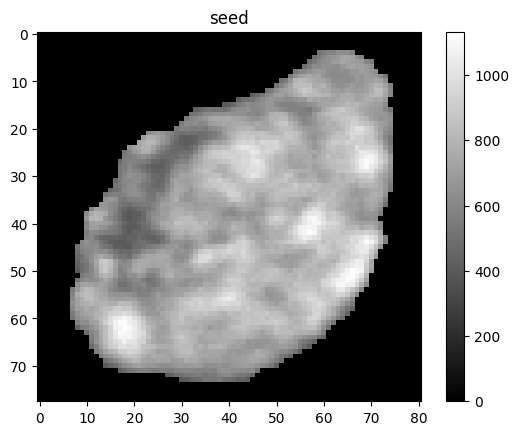

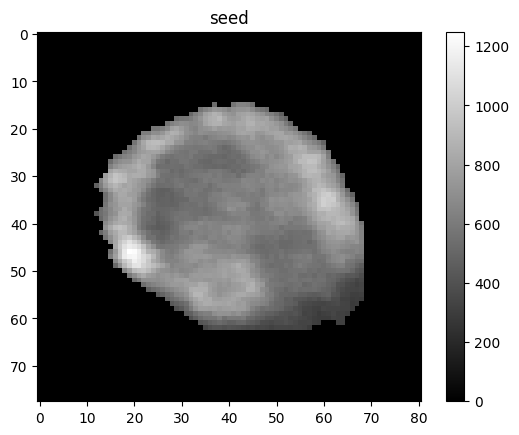

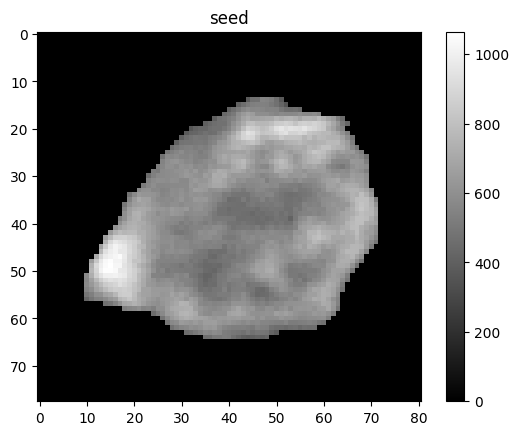

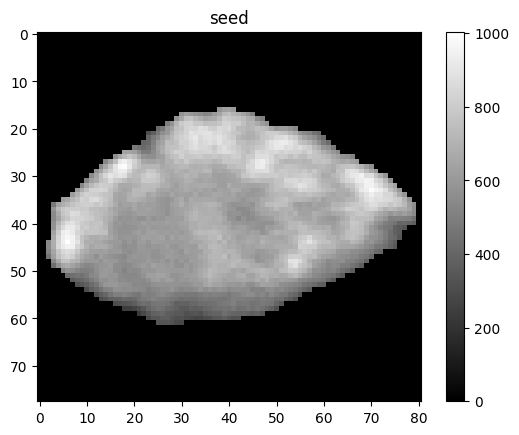

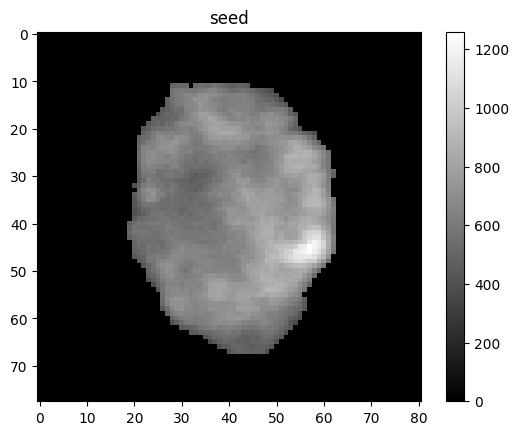

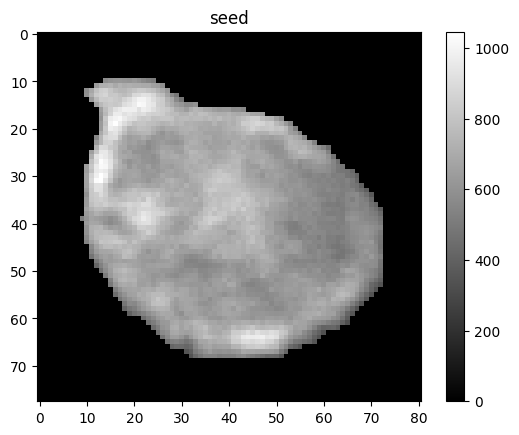

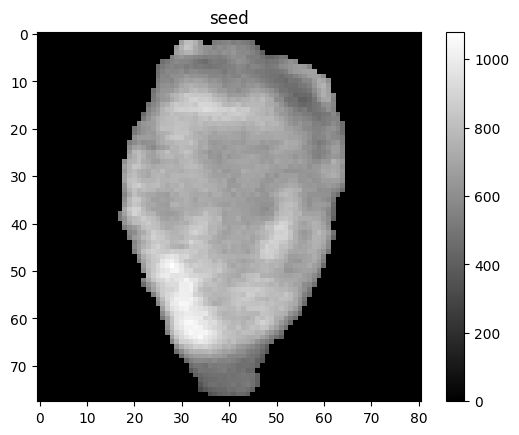

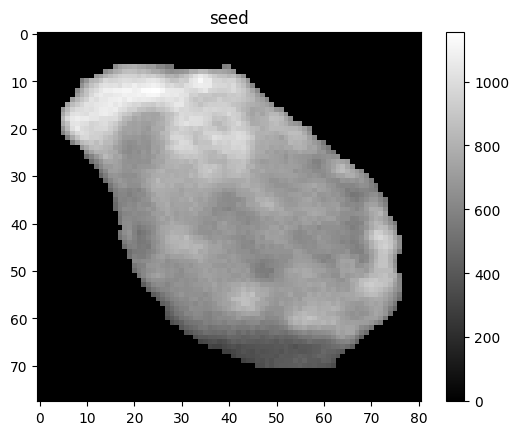

In [85]:
max_width, max_height, _ = find_max_width_height_area_of_seeds('home')
seed_paths = find_paths_of_seeds('home')
for path in seed_paths:
    resized_image = resize_seeds_to_max(np.load(os.path.join('home', path))[:,:,200].squeeze(), max_width, max_height)
    display_seed(resized_image)